### Example notebook to decribe geojson reading, sub-regioning, rasterize, vectorise operations

First, let's import some libraries needed to add geostack in python path

In [1]:
import os
import sys
import os.path as pth
from time import time
from textwrap import dedent
import json
from zipfile import ZipFile

And, some modules for plotting the results

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from osgeo import gdal, ogr, osr
import shapely
import geopandas as gpd

Now, import the required geostack modules

In [3]:
from geostack.io.geo_json import geoJsonToVector, vectorToGeoJson
from geostack.vector.vector import Vector, BoundingBox
from geostack.raster.raster import Raster, GeometryType
from geostack.core import ProjectionParameters

In [4]:
def build_grid(nx, ny, ox, oy, hx, hy):
    xx = np.arange(ox, ox+hx*nx, hx)
    yy = np.arange(oy, oy+hy*ny, hy)
    return np.meshgrid(xx, yy)

In [5]:
file_path = pth.join(os.getcwd(), "data", "testProcessing")

In [6]:
if pth.exists("test_contour.geojson"):
    os.remove("test_contour.geojson")
if pth.exists("test_raster.asc"):
    os.remove("test_raster.asc")
if pth.exists("test_subregion.geojson"):
    os.remove("test_subregion.geojson")

#### Reading geojson file

Python wrapper for c++ geojson function can handle both string and file path. As a first example, I will read a geojson file, where I provide the path of the file. One of the key things to note here is that when reading a geojson file to a vector class, it is important to provide the datatype desired for the returned vector class

Following is the projection information for EPSG:4326, which is the usual (Longitude,Latitude).

In [7]:
EPSG4326 = 'GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.01745329251994328,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]]'

and, the projection information for EPSG:3111.

In [8]:
EPSG3111 = 'PROJCS["GDA94 / Vicgrid94",GEOGCS["GDA94",DATUM["Geocentric_Datum_of_Australia_1994",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],TOWGS84[0,0,0,0,0,0,0],AUTHORITY["EPSG","6283"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.01745329251994328,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4283"]],UNIT["metre",1,AUTHORITY["EPSG","9001"]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["standard_parallel_1",-36],PARAMETER["standard_parallel_2",-38],PARAMETER["latitude_of_origin",-37],PARAMETER["central_meridian",145],PARAMETER["false_easting",2500000],PARAMETER["false_northing",2500000],AUTHORITY["EPSG","3111"],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'

First, read the Victorian road network from a GeoJSON file. The GeoJSON is stored in a zip file, so we will open the zip file using `ZipFile` and the parse it using `geoJsonToVector`.

In [9]:
start = time()
with ZipFile(pth.join(file_path, "test_data_2.zip")) as inp:
    victoria_network = geoJsonToVector(inp.read(inp.filelist[0].filename).decode())
end = time()
print("Time taken for reading geojson %f" % (end - start))

Time taken for reading geojson 0.033191


In [10]:
network_projection = ProjectionParameters.from_wkt(EPSG4326)
victoria_network.setProjectionParameters(network_projection)

#### Converting a geojson string to  a vector

In [11]:
region = dedent('''{"features": [{"geometry": {"coordinates": [[[2383894, 2446687], 
                                                                [2450835, 2446687], 
                                                                [2450835, 2489513], 
                                                                [2383894, 2489513], 
                                                                [2383894, 2446687]]], 
                                                "type": "Polygon"}, 
                                                "properties": {}, 
                                                "type": "Feature"}], 
                "type": "FeatureCollection"}''')

As we can see, the coordinates for the **Polygon** are not in usual (Longitude,Latitude). They are in a projected coordinate system EPSG:3111, so we will set the projection for the region.

In [12]:
bbox_vector = geoJsonToVector(region)
bbox_projection = ProjectionParameters.from_wkt(EPSG3111)
bbox_vector.setProjectionParameters(bbox_projection)

To see the bounds of the vector class, you can call the `getBounds` method which returns an instance of `BoundingBox` class. To get the actual values of the bounding box, you can call `to_list` method on the returned `BoundingBox` class

In [13]:
bounds = bbox_vector.getBounds().to_list()
print(bounds)

[[2383894.0, 2446687.0, 0.0, 0.0], [2450835.0, 2489513.0, 0.0, 0.0]]


#### Sub-region a vector

To sub-region a vector, you can call `region` method on the vector class, which accepts an instance of `BoundingBox` class. If you don't have an instance of `BoundingBox` class, you can import it from the `vector` module and call `from_list` method on the `BoundingBox` class which can thereafter be passed to the `region` method

In [14]:
bbox_from_list = BoundingBox.from_list(bounds)
bbox_proj = bbox_from_list.convert(network_projection, bbox_projection)

Above, you can see that when you create an instance of `BoundingBox` class, you need to pass the data type that you desire for the said `BoundingBox`. If the `BoundingBox` has a different projection from the `Vector` object i.e. Victorian road network, then, it should be projected onto the same projection before sub-setting.

In [15]:
subset = victoria_network.region(bbox_proj)

After calling `region` method on the **Vector** object, we get a **Vector** which spans the provided region. we can check it by calling the `getBounds` method on the subset.

In [16]:
bounds = subset.getBounds().to_list()
print(bounds)

[[143.64794921875, -37.48339080810547, 0.0, 0.0], [144.4541015625, -37.067501068115234, 0.0, 0.0]]


Above, we can see that the subset region has the same bounds as the `BoundingBox`. We can now obtain a geojson from the `Vector` object using `vectorToGeoJson` method, and use the returned geojson for visualisation.

In [17]:
out_geojson = json.loads(vectorToGeoJson(subset))
for i in range(len(out_geojson['features'])):
    if 'properties' not in out_geojson['features'][i]:
        out_geojson['features'][i]['properties'] = {}

As geojson does't have projection attached to it, so I used some gdal stuff to work out that data is in EPSG 3111 projection

In [18]:
# out_shp = shapely.geometry.GeometryCollection([shapely.geometry.shape(feature['geometry']) 
#                                      for feature in json.loads(out_geojson)['features']])
# to = osr.SpatialReference()
# to.ImportFromEPSG(4326)
# source = osr.SpatialReference()
# source.ImportFromEPSG(3111)
# transform = osr.CoordinateTransformation(source, to)
# geom = ogr.CreateGeometryFromJson(json.dumps(out_shp.__geo_interface__))
# geom.Transform(transform)

Below, you can see a plot with the victoria bounds on the axis tick labels

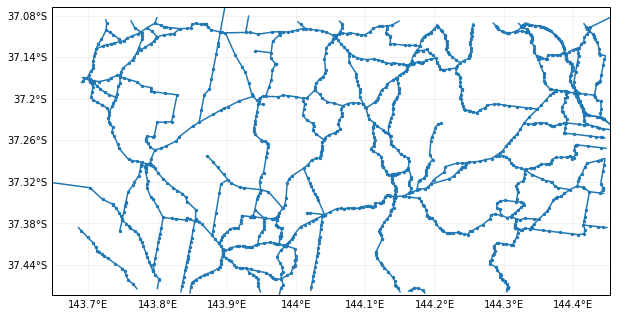

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8),
                        subplot_kw={'projection':ccrs.PlateCarree()})
ax.set_extent([bounds[0][0], bounds[1][0], 
               bounds[0][1], bounds[1][1]], 
              crs=ccrs.PlateCarree())

subset_df = gpd.GeoDataFrame.from_features(out_geojson['features'])
subset_df.plot(ax=ax, transform=ccrs.PlateCarree(),
               markersize=5.5)
gl = ax.gridlines(draw_labels=True, alpha=0.2)
gl.xlabels_top = gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

#### Writing geojson out

In [20]:
with open("test_subregion.geojson", "w") as outfile:
    outfile.write(json.dumps(out_geojson))

In [21]:
ls

 Volume in drive C has no label.
 Volume Serial Number is A06E-7E8D

 Directory of C:\Users\mar582\Downloads\nikhil\notebooks

24/03/2020  10:54 PM    <DIR>          .
24/03/2020  10:54 PM    <DIR>          ..
20/03/2020  04:56 PM    <DIR>          .ipynb_checkpoints
11/03/2020  06:29 PM    <DIR>          data
20/03/2020  11:06 PM            11,732 matpred1_py.ipynb
11/03/2020  11:54 AM           379,601 NetCDF_IO.ipynb
12/03/2020  05:05 PM            18,696 NetworkFlowSolver.ipynb
20/03/2020  10:33 AM            29,449 onerunXareasumm.ipynb
12/03/2020  01:12 PM         2,248,879 out_flow_network.geojson
19/03/2020  09:19 AM            20,832 SubRegion.ipynb
12/03/2020  11:37 AM         3,657,862 test_raster.tif
24/03/2020  10:54 PM           497,002 test_subregion.geojson
12/03/2020  05:22 PM    <DIR>          Untitled Folder
12/03/2020  05:17 PM             5,366 Untitled.ipynb
12/03/2020  05:18 PM               555 Untitled1.ipynb
12/03/2020  01:11 PM            20,107 vector_contou

#### Example rasterize

To rasterize the vector object, we can `mapDistance` method with a specified resolution for the output raster

In [22]:
start = time()
testRasterize = subset.mapDistance(0.0005, GeometryType.LineString, bbox_proj)
end = time()
print("Time taken to rasterize %f" % (end - start))

Time taken to rasterize 1.191381


#### Saving raster to asc file

We can save the raster using `RasterToAscii` method from `geostack.io` module

In [23]:
testRasterize.write("test_raster.tif", jsonConfig="")

True

In [24]:
raster_data = testRasterize.writeData()

To plot the raster, we will first create a grid. The raster class has all the information needed to create a grid. We can use following simple function to return a two dimensional grid

In [25]:
raster_dimensions = testRasterize.getDimensions()

In [26]:
xx, yy = build_grid(raster_dimensions.nx, raster_dimensions.ny, 
                    raster_dimensions.ox, raster_dimensions.oy,
                    raster_dimensions.hy, raster_dimensions.hy)

Now, we can plot the raster with the vector subsetted earlier. 

Here, it is important to note that `Raster` objects within **geostack** are tiled, therefore, to plot a complete raster, we need to get the data from all the tiles. A convenience method `get_full_data` is provided with `Raster` object to return raster data as a numpy array.

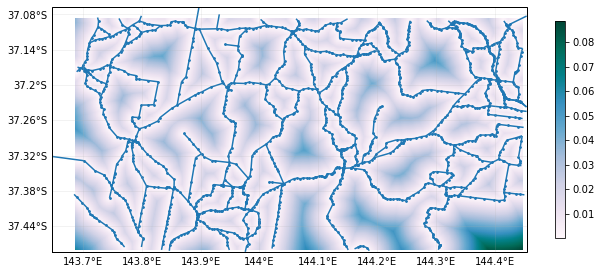

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8),
                        subplot_kw={'projection':ccrs.PlateCarree()})
ax.set_extent([bounds[0][0], bounds[1][0], 
               bounds[0][1], bounds[1][1]], 
              crs=ccrs.PlateCarree())

cs = ax.pcolormesh(xx, yy, testRasterize.get_full_data(), cmap=plt.cm.PuBuGn, 
                   transform=ccrs.PlateCarree())

fig.colorbar(cs, ax=ax, shrink=0.5, fraction=0.1)

subset_df = gpd.GeoDataFrame.from_features(out_geojson['features'])
subset_df.plot(ax=ax, transform=ccrs.PlateCarree(), markersize=3)

gl = ax.gridlines(draw_labels=True, alpha=0.2)
gl.xlabels_top = gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

#### Example vectorise

For vectorise, we can call `vectorise` method on the raster object. Here, we obtain a buffer from the road network at a distance of 0.01 which is approximately 1km.

In [28]:
contourVector = testRasterize.vectorise(0.01)

Similar to above, we can save the `Vector` object to a GeoJSON file using `vectorToGeoJson` method.

In [29]:
contour_geojson = vectorToGeoJson(contourVector)
with open('test_contour.geojson', 'w') as outfile:
    outfile.write(contour_geojson)

In [30]:
contour_geojson = json.loads(contour_geojson)
for i in range(len(contour_geojson['features'])):
    if 'properties' not in contour_geojson['features'][i]:
        contour_geojson['features'][i]['properties'] = {}

Now, we can plot all three elements, i.e. subset vector file, raster and contour obtained from raster

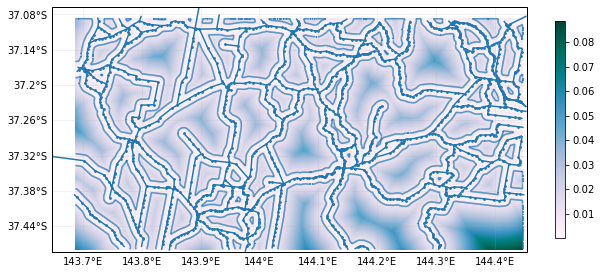

In [31]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8),
                        subplot_kw={'projection':ccrs.PlateCarree()})
ax.set_extent([bounds[0][0], bounds[1][0], 
               bounds[0][1], bounds[1][1]], 
              crs=ccrs.PlateCarree())

cs = ax.pcolormesh(xx, yy, testRasterize.get_full_data(), cmap=plt.cm.PuBuGn, 
                   transform=ccrs.PlateCarree())

fig.colorbar(cs, ax=ax, shrink=0.5, fraction=0.1)

subset_df = gpd.GeoDataFrame.from_features(out_geojson['features'])
subset_df.plot(ax=ax, transform=ccrs.PlateCarree(), markersize=3)

subset_df = gpd.GeoDataFrame.from_features(contour_geojson['features'])
subset_df.plot(ax=ax, transform=ccrs.PlateCarree())

gl = ax.gridlines(draw_labels=True, alpha=0.2)
gl.xlabels_top = gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER